# Download data

Download the data from <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/weatherAUS.zip" target="_blank"> weather data</a> and unpack it to the Data folder.

# Decision Trees & Random forests

**Outline**

In this tutorial we learn how to train CART, CHAID decision trees and random forests on real data and how to evaluate them. We also create simple random forest.

We proceed as follows:

- import data and handle missing values
- split data to train and test samples using stratification
- separately for CART and CHAID models we perform
    - train decision tree and assess the performance
    - inspect importance of predictors (available for CART only)
    - evaluate the model performance in time
- based on CART tree we manually construct random forest
- we create and assess random forest model separately using two different encodings of categorical predictors
    - one-hot encoding
    - mean-target encoding
    
Additional resources:

- https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://github.com/WillKoehrsen/Data-Analysis

    
Implementation limitations: CART only supports continuous predictors, whereas CHAID supports only categorical (either nominal or ordinal)

**Important notice, last practical we dealt with the missing values, infinities and new categories properly, this time we take a few shortcuts as the important and new part are the decision trees not the data handling and preparation**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import sample

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

import CHAID

pd.set_option('mode.chained_assignment',None)

C:\Users\nemec\Documents\MFF UK\_Magisterské\Data_Science_2\.venv\lib\site-packages\CHAID\graph.py:13: UserWarning: Imports of optional packages needed to generate graphs failed. Please install with the "graph" option.
  warnings.warn(UserWarning('Imports of optional packages needed to generate graphs failed. Please install with the "graph" option.'))


## Load data

Weather data from Australia. The task is to predict if tomorrow is going to rain based on today's weather characteristics.

Source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

**Target description**

- RainTomorrow: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0 for the next day

**Predictors description**

- MinTemp: The minimum temperature in degrees celsius
- MaxTemp: The maximum temperature in degrees celsius
- Sunshine: The number of hours of bright sunshine in the day.
- WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
- Humidity9am: Humidity (percent) at 9am
- Humidity3pm: Humidity (percent) at 3pm
- Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
- Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
- RainToday: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0




We import data and keep only several columns for simplicity and certain time period for simplicity.

In [2]:
# Import dataset
data_file = Path("../Data/weatherAUS.csv")
data_all = pd.read_csv(data_file, encoding='utf-8')

# Keep only specified columns and rows
columns = ["Date", "MinTemp", "MaxTemp", "Sunshine", "WindGustSpeed", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "RainToday", "RainTomorrow"]
data = data_all.loc[data_all['Date']>='2016-01-01', columns]

# Convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

print(f'Number of rows:      {data.shape[0]}')
print(f'Number of columns:   {data.shape[1]}')

Number of rows:      26557
Number of columns:   11


In [3]:
data.head()

,Date,MinTemp,MaxTemp,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
2498,2016-01-01,20.4,37.6,NaN,54.0,46.0,17.0,1013.4,1009.2,No,No
2499,2016-01-02,20.9,33.6,NaN,50.0,54.0,30.0,1011.1,1008.4,No,Yes
2500,2016-01-03,18.4,23.1,NaN,48.0,62.0,67.0,1014.0,1014.8,Yes,Yes
2501,2016-01-04,17.3,23.7,NaN,39.0,74.0,65.0,1017.9,1016.5,Yes,Yes
2502,2016-01-05,15.5,22.9,NaN,31.0,92.0,63.0,1016.3,1013.9,Yes,No


# CART

Implementation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

We use implementation from sci-kit learn package. The implementation has several characteristics:

- Missing values are not supported
- Assumes the predictors to be numeric variables (either continuous or ordinal categories). 
- Both categorical and continuous targets are possible (we chose either DecisionTreeClassification or DecisionTreeRegression class according to our task)

Short description:

In each node we iterate over randomly chosen set of predictors and compute gain for each predictors measured using defined measure and assuming different possible splits over this predictor. Using the best predictor we perform split into two subtrees. See details of the implementation for further parameters that influence stopping of the algorithm.

## Data Manipulation

We copy our data to 'data_cart' dataframe.

First, we handle missing values, then encode all predictors as numerical.

In [4]:
data_cart = data.copy()

In [10]:
data_cart.head()

,Date,MinTemp,MaxTemp,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,RainTodayFlag,RainTomorrowFlag,RainToday_missing
2498,2016-01-01,20.4,37.6,NaN,54.0,46.0,17.0,1013.4,1009.2,No,No,0,0,0
2499,2016-01-02,20.9,33.6,NaN,50.0,54.0,30.0,1011.1,1008.4,No,Yes,0,1,0
2500,2016-01-03,18.4,23.1,NaN,48.0,62.0,67.0,1014.0,1014.8,Yes,Yes,1,1,0
2501,2016-01-04,17.3,23.7,NaN,39.0,74.0,65.0,1017.9,1016.5,Yes,Yes,1,1,0
2502,2016-01-05,15.5,22.9,NaN,31.0,92.0,63.0,1016.3,1013.9,Yes,No,1,0,0


### Predictor type

In [22]:
# We check the format of the data
data_cart.dtypes

Date                 datetime64[ns]
MinTemp                     float64
MaxTemp                     float64
Sunshine                    float64
WindGustSpeed               float64
Humidity9am                 float64
Humidity3pm                 float64
Pressure9am                 float64
Pressure3pm                 float64
RainToday                    object
RainTomorrow                 object
RainTodayFlag                 int64
RainTomorrowFlag              int64
RainToday_missing             int32
dtype: object

<span style="color:red">**TO DO:** </span> \
Re-encode. Column 'Date' will not be used for prediction, therefore, no need to encode it. Only 'RainToday' and 'RainTomorrow' should be re-encoded. \
Convert values of 'RainToday' and 'RainTomorrow' into 0-1 encoding. You can use .apply function to use row-by-row notation. 

In [7]:
data_cart['RainTodayFlag'] = data_cart['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
data_cart['RainTomorrowFlag'] = data_cart['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
# add flag whether RainToday is missing
data_cart['RainToday_missing'] = data_cart['RainToday'].isna().astype(int)

In [9]:
# another way how to reencode using faster np.where function
all(np.where(data_cart['RainToday']=='Yes', 1, 0) == data_cart['RainToday'].apply(lambda x: 1 if x=='Yes' else 0))

True

In [19]:
# We denote 'target' the name of the column with target values. 'predictors' stands for the list of all predictors

target = 'RainTomorrowFlag'

predictors = columns.copy()
predictors.remove('Date')
predictors.remove('RainToday')
predictors.remove('RainTomorrow')
predictors += ["RainTodayFlag"]
predictors += ['RainToday_missing']

In [20]:
predictors

['MinTemp',
 'MaxTemp',
 'Sunshine',
 'WindGustSpeed',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainTodayFlag',
 'RainToday_missing']

### Missing values

In [21]:
# Number of missing values in each column
data_cart.isna().sum()

Date                     0
MinTemp                333
MaxTemp                316
Sunshine             18386
WindGustSpeed         1636
Humidity9am            470
Humidity3pm           1959
Pressure9am           2869
Pressure3pm           2870
RainToday              577
RainTomorrow           583
RainTodayFlag            0
RainTomorrowFlag         0
RainToday_missing        0
dtype: int64

In [24]:
# Handle missing values for predictors in a fast manner, optimal would be to consider missing as another category
data_cart=data_cart[pd.isnull(data_cart['RainTomorrow'])==False]
data_cart[predictors]=data_cart[predictors].fillna(data_cart[predictors].mean())

In [25]:
data_cart[predictors + [target]].isna().sum()

MinTemp              0
MaxTemp              0
Sunshine             0
WindGustSpeed        0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
RainTodayFlag        0
RainToday_missing    0
RainTomorrowFlag     0
dtype: int64

In [26]:
data_cart['Date']

2498     2016-01-01
2499     2016-01-02
2500     2016-01-03
2501     2016-01-04
2502     2016-01-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 25974, dtype: datetime64[ns]

## Split & train

We split the data into train and test datasets. We use stratification by a combination of year and month for further model evaluation (i.e. 201706, 201707,...).

In [27]:
# we have observation from 2 years
data_cart['Month'] = data_cart['Date'].dt.strftime('%m')
data_cart['Month'].value_counts()

Month
05    3007
03    2945
01    2943
04    2885
02    2714
06    2660
08    1515
07    1511
10    1499
09    1444
11    1434
12    1417
Name: count, dtype: int64

In [28]:
data_cart['Year'] = data_cart['Date'].dt.year
data_cart['Year'].value_counts()

Year
2016    17508
2017     8466
Name: count, dtype: int64

In [29]:
data_cart['YearMon'] = data_cart['Year'].astype(str) + (data_cart['Month']).astype(str)
data_cart['YearMon'].value_counts()

YearMon
201608    1515
201607    1511
201605    1506
201705    1501
201610    1499
201701    1492
201703    1480
201603    1465
201606    1463
201704    1451
201601    1451
201609    1444
201611    1434
201604    1434
201612    1417
201602    1369
201702    1345
201706    1197
Name: count, dtype: int64

<span style="color:red">**TO DO:** </span> \
Split the data into 'data_cart_train' and 'data_cart_test' datasets. Use stratification by 'YearMon'. \
Use function 'train_test_split' from 'sklearn.model_selection' package and choose parameters carefully.

In [31]:
data_cart_train, data_cart_test = train_test_split(
    data_cart, test_size=0.2, random_state=17, stratify=data_cart["YearMon"]
)

<span style="color:red">**TO DO:** </span> \
Check the documentation for parameters' interpretation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier \
Build the model and choose the parameters carefully.

In [49]:
# Now we can fit the model.

criterion = "gini" #(TODO)
splitter = "best" #(TODO)
mdepth = 5 #(TODO)
min_samples_split = 6 #(TODO)
min_samples_leaf = 0.0001 #(TODO)
random_state = 17

# Now we contruct the model.
model = tree.DecisionTreeClassifier(
    criterion=criterion,
    splitter=splitter, 
    max_depth=mdepth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf, 
    random_state=random_state, 
)

# And fit training data.

clf = model.fit(data_cart_train[predictors], data_cart_train[target])

# Predict class labels on training data
pred_labels_tr = model.predict(data_cart_train[predictors])
# Predict class labels on a test data
pred_labels_te = model.predict(data_cart_test[predictors])

# Tree summary and model evaluation metrics
print('*************** Tree Summary ***************')
print('Classes: ', clf.classes_)
print('Tree Depth: ', clf.tree_.max_depth)
print('No. of leaves: ', clf.tree_.n_leaves)
print('No. of features: ', clf.n_features_in_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = model.score(data_cart_test[predictors], data_cart_test[target])
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(data_cart_test[target], pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = model.score(data_cart_train[predictors], data_cart_train[target])
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(data_cart_train[target], pred_labels_tr))
print('--------------------------------------------------------')

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  5
No. of leaves:  32
No. of features:  10
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8273339749759384
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4007
           1       0.69      0.45      0.55      1188

    accuracy                           0.83      5195
   macro avg       0.77      0.70      0.72      5195
weighted avg       0.81      0.83      0.81      5195

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8344001155012272
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     16021
           1       0.70      0.48      0.57      4758

    accuracy                           0.83     20779
   macro avg       0.78      0.71  

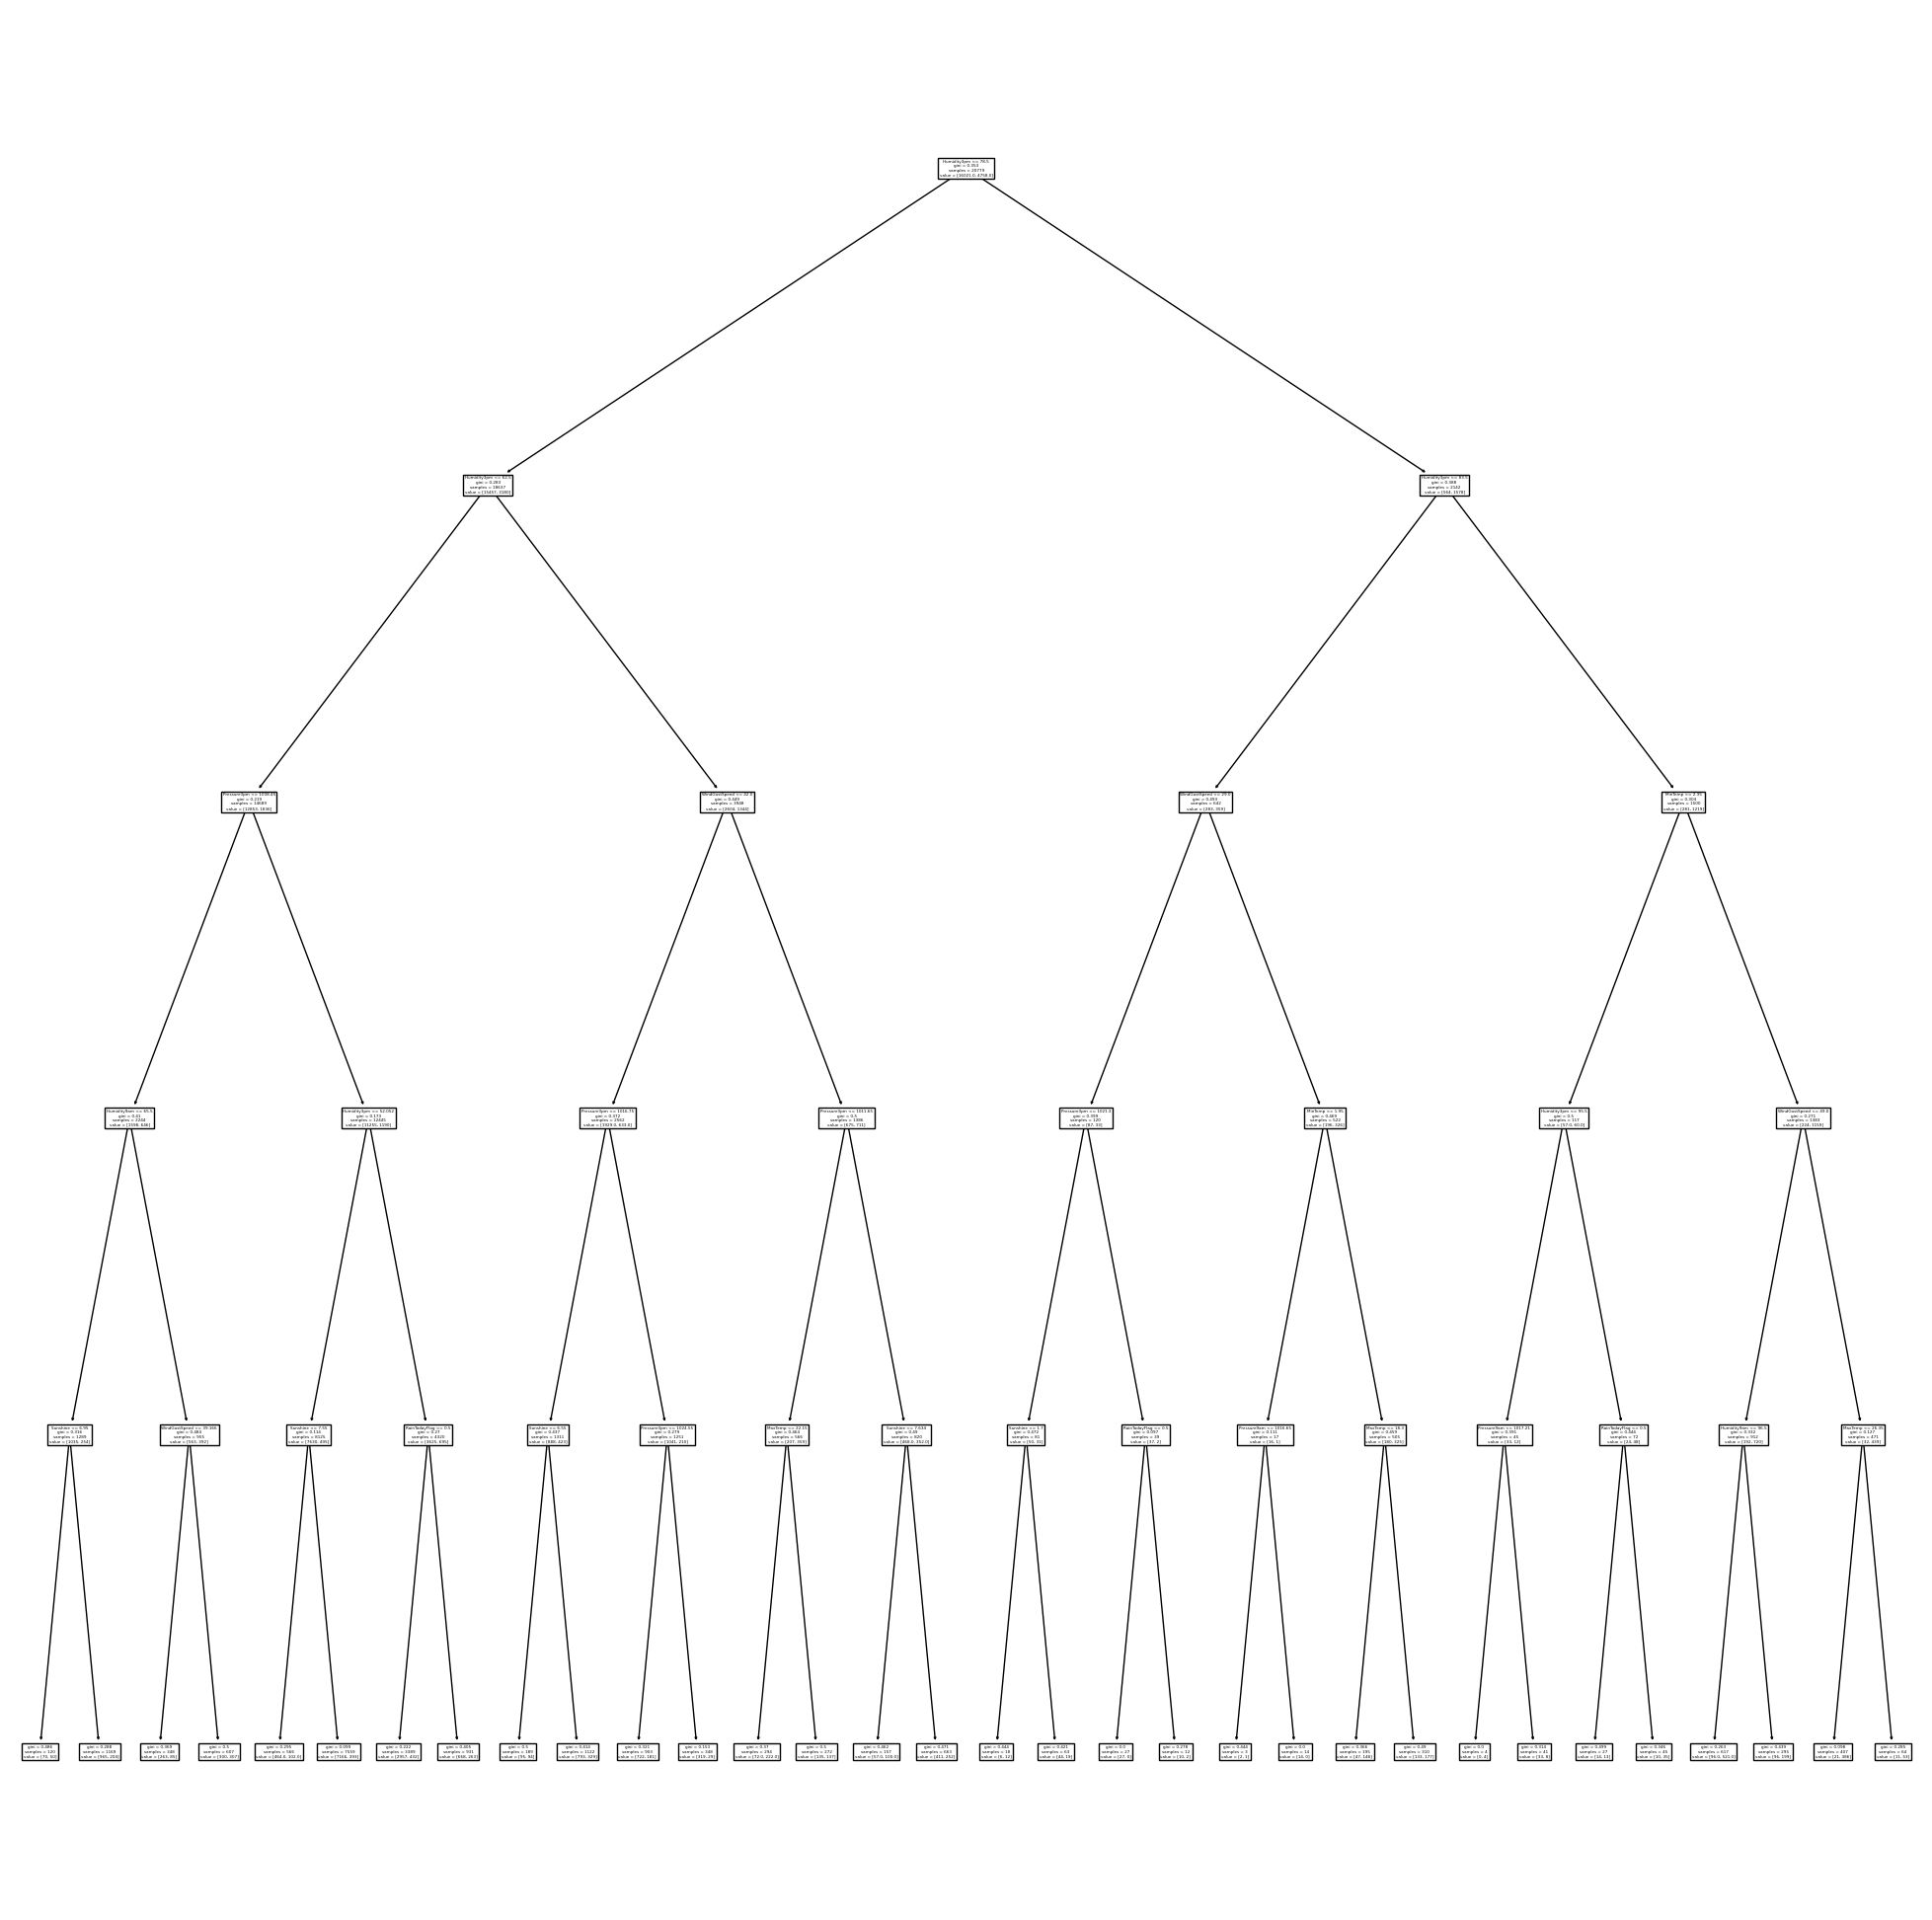

In [50]:
# We can plot the tree structure.

# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

fig, ax = plt.subplots(figsize=(25, 25))
tree.plot_tree(clf, ax=ax, feature_names=predictors)
plt.show()

## Evaluate

We evaluate performance

- we inspect accuracy of the predictions on test data month by month
- we evaluate predictors importance

### Accuracy

<span style="color:red">**TO DO:** </span> \
Predict target variable on test data in two steps
- use 'predict_proba' method for 'DecisionTreeClassifier'
- convert result to 0/1 values using some threshold (could be done in one step but we want to observer dependence on the threshold) 

Finally store the prediction as 'Prediction' column

In [60]:
data_cart_test['Prediction_prob'] = clf.predict_proba(data_cart_test[predictors])[:,1]
data_cart_test['Prediction'] = (data_cart_test['Prediction_prob']>=0.5).astype(int) 

<span style="color:red">**TO DO:** </span> \
Compute accuracy by 'Month'. Store the result to pd.Series 'data_cart_accuracy'

In [80]:
data_cart_test['Accuracy'] = 1-abs(data_cart_test[target] - data_cart_test['Prediction'])
data_cart_accuracy = data_cart_test.groupby('Month')['Accuracy'].mean()
data_cart_accuracy

Month
01    0.799660
02    0.834254
03    0.831919
04    0.850953
05    0.828619
06    0.864662
07    0.791391
08    0.831683
09    0.750865
10    0.816667
11    0.885017
12    0.805654
Name: Accuracy, dtype: float64

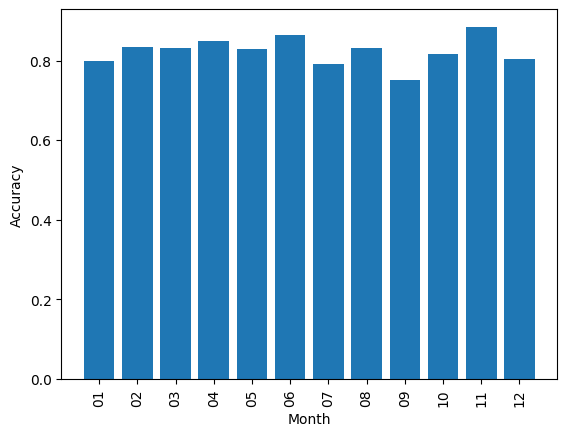

In [76]:
# Inspect stability of the model performance in time

ax1 = plt.subplot(111)
ax1.bar(range(len(data_cart_accuracy)), data_cart_accuracy)
ax1.set_xticks(range(len(data_cart_accuracy)))
ax1.set_xticklabels(data_cart_accuracy.index, rotation = 90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Accuracy')

plt.show()

### Predictor importance

In scikit-learn the feature importance is the decrease in node impurity. The key is that it measures the importance only at a node level. Then, all the nodes are weighted by how many samples reach that node.

In [83]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(predictors, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Humidity3pm          Importance: 0.72
Variable: WindGustSpeed        Importance: 0.09
Variable: Pressure3pm          Importance: 0.09
Variable: Sunshine             Importance: 0.03
Variable: Humidity9am          Importance: 0.03
Variable: RainTodayFlag        Importance: 0.02
Variable: MinTemp              Importance: 0.01
Variable: MaxTemp              Importance: 0.01
Variable: Pressure9am          Importance: 0.0
Variable: RainToday_missing    Importance: 0.0


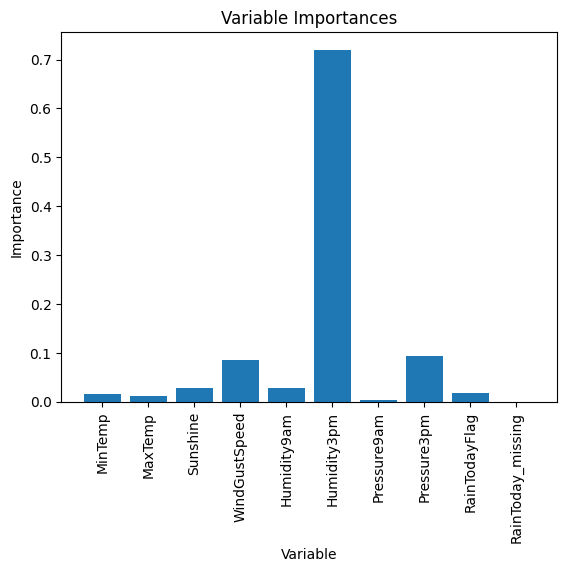

In [84]:
# Plot importance
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, predictors, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# CHAID

Implementation: https://github.com/Rambatino/CHAID

Documentation: https://www2.karlin.mff.cuni.cz/~kozmikk/files/TREE-CHAID.pdf

- supports missing values for predictors (treated as a category)
- assumes the predictors to be categorical (either nominal or ordinal)
- the same implementation works also for regression (choose the dependent variable to be continuous)

Short description:

Continuous predictors are assumed to be categorized either in 'nominal' or 'ordinal' (e.g. deciles) format. Target is either 'nominal' or 'continuous'.

We define constants alpha_merge and split_threshold.

In each node we iterate over all categories of all predictors and test if they significantly influence the target value in terms of Chi-square test if target is 'categorical' or F-test if target is continuous. Categories are merged until the significance is below alpha_merge. Now we iterate over such newly categorized predictors and split using the one with the most significant influence on target (using the same measure as above) if split_threshold is triggered by any of them. We obtain possibly split which is non-binary.

Additional parameters:

- the above procedure is repeated only until the depth of the tree is not larger then max_depth
- if we have less then min_parent_node_size in given node, no splitting is performed
- if splitting would result in new node with less then min_child_node_size observations, no splitting is performed
- if is_exhaustive is true then all possible merging combinations of given predictor's categories are examined (according to https://www.researchgate.net/publication/332591728_Classification_of_air_traffic_control_scenarios_using_decision_trees_insights_from_a_field_study_in_terminal_approach_radar_environment, note that the significance is adjusted using Bonferroni method)

## Data Manipulation

We copy our data to 'data_chaid' dataframe.

First, we handle missing values, then encode all predictors as numerical.

In [ ]:
data_chaid = data.copy()

### Missing values

In [ ]:
# TODO: Handle missing values for both predictors and target

data_chaid=data_chaid[pd.isnull(data_chaid['RainTomorrow'])==False] #(TODO)
data_chaid=data_chaid #(TODO) no need to fill missing predictors in this implementation

### Predictor type

In [ ]:
data_chaid.dtypes

In [ ]:
# Re-encode. Column 'Date' will not be used for prediction, therefore, no need to encode it. Only 'RainToday' and 'RainTomorrow' should be re-encoded.

# TODO: Convert values of 'RainToday' and 'RainTomorrow' into 0-1 encoding. You can use .apply function to use row-by-row notation.
data_chaid['RainTodayFlag']=data_chaid['RainToday'].apply(lambda x: 1 if x=='Yes' else 0) #(TODO)
data_chaid['RainTomorrowFlag']=data_chaid['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0) #(TODO)

In [ ]:
target = 'RainTomorrowFlag'

predictors_chaid = list(data_chaid.columns)
predictors_chaid.remove('Date') # Date will not be used for training
predictors_chaid.remove('RainToday') # We use RainTodayFlag instead
predictors_chaid.remove('RainTomorrow') # Target
predictors_chaid.remove('RainTomorrowFlag') # Target# We denote 'target' the name of the column with target values. 'predictors' stands for the list of all predictors

In [ ]:
# Create column 'Month' for future evaluation of the model performance in time
data_chaid['Month'] = [s.strftime("%Y%m") for s in data_chaid['Date']]
data_chaid['Month'].value_counts()

In [ ]:
# We check the predictors if we can assume that these are continuous

for predictor in predictors_chaid:
    
    plt.hist(data_chaid[predictor], density=True, bins=10)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel(predictor);

    plt.show()

## Split & categorize

Based on the histograms above we conclude that some of the predictors must be categorized. We do the categorization based on training data only, therefore, now we have to split the dataset.

In [ ]:
# Split the data, stratify by month
data_chaid_train, data_chaid_test = train_test_split(
    data_chaid, test_size=0.2, random_state=17, stratify=data_chaid['Month']
)

In [ ]:
# Only 'RainTodayFlag' predictor is categorical. The rest is continuous, therefore we have to categorize.

n_cat = 10 # number of categories created for each predictor

# We store categorized predictors from 'predictors_chaid' to 'predictors_chaid_cat' columns.

predictors_chaid_cat = []
for predictor in predictors_chaid:
    
    predictor_cat = predictor+'_cat'
    predictors_chaid_cat.append(predictor_cat)
    
    if (predictor not in ['RainTodayFlag']): # 'RainTodayFlag' need not to be categorized
        
        # TODO: Categorize given predictor 'predictor' by quantiles using function pd.qcut with 'n_cat' categories. 
        # Note that in the future we will need to categorize also test data, therefore, label the
        # new categories by right-end-point of each interval (np.infty for infinity).
        data_chaid_train[predictor_cat] = pd.qcut(data_chaid_train[predictor], q=n_cat, labels=None, duplicates='drop') #(TODO)
        data_chaid_train[predictor_cat] = data_chaid_train[predictor_cat].apply(lambda x: x.right).astype(float) #(TODO)
        pred_max = data_chaid_train[predictor_cat].max() #(TODO)
        data_chaid_train.loc[data_chaid_train[predictor_cat] == pred_max, predictor_cat] = np.infty #(TODO)
        
    else:
        # Already categorized
        data_chaid_train[predictor_cat] = data_chaid_train[predictor]


## Train

In [ ]:
# Now we can fit the model.

# The model needs to know if 'ordinal' or 'nominal' predictors are present (only 'nominal' in our case as we have also missing values)
independent_columns = dict(zip(predictors_chaid_cat, ['nominal'] * len(predictors_chaid_cat)))

# TODO: Choose the parameters carefully. See the algorithm description above.
config_chaid = {
    'alpha_merge': 0.05, # minimum significance level for categories not to be merged (TODO)
    'max_depth': 3, #maximum depth of tree (TODO)
    'min_parent_node_size': 30, # minimum number of observations of node for splitting (TODO)
    'min_child_node_size': 15, # minimum number of observations in new node (TODO)
    'split_threshold': 0, # minimum gain for new split (TODO)
}

tree_ch = CHAID.Tree.from_pandas_df(
    data_chaid_train,
    independent_columns,
    target,
    alpha_merge = config_chaid['alpha_merge'],
    max_depth = config_chaid['max_depth'],
    min_parent_node_size = config_chaid['min_parent_node_size'],
    min_child_node_size = config_chaid['min_child_node_size'],
    split_threshold = config_chaid['split_threshold'],
)

# Tree summary and model evaluation metrics
print('*************** Tree Summary ***************')
print('Classes: ', len(data_chaid_train[target].unique()))
print('Tree Depth: ', tree_ch.max_depth)
print('No. of features: ', len(independent_columns))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
print('Accuracy Score: ', tree_ch.accuracy())

Note: features_importance not available in this implementation

## Evaluate

We evaluate performance of the model using accuracy month by month.

Before we can predict for test data, we have to use the same categorization as for the train data.

### Predict

In [ ]:
# First, we need to categorize the test data in the same way as we have categorized the train data

for predictor in predictors_chaid:
    
    predictor_cat = predictor+'_cat'
    
    if (predictor not in ['RainTodayFlag']): # 'RainTodayFlag' need not be categorized
        
        # TODO: Categorize predictor 'predictor' using intervals from train data. Use the function
        # pd.cut.
        labels=list(data_chaid_train[predictor_cat].unique()) # We take the right-end points of intervals from train data
        labels = sorted([x for x in labels if str(x) != 'nan']) # We drop 'nan' end point which stands for missing values
        bins = [-np.inf] + labels #(TODO)
        data_chaid_test[predictor_cat] = pd.cut(data_chaid_test[predictor], bins=bins, labels=labels, duplicates='drop').astype(float) #(TODO)
    else:
        # Already categorized
        data_chaid_test[predictor_cat] = data_chaid_test[predictor]


In [ ]:
# Disclaimer: The implementation does not involve method for prediction. Therefore, we use our own implementation.

# Leaves of the tree: list of leaves with rules
leaves = tree_ch.classification_rules() # Contains rules for leaves
nodes = tree_ch.tree_store # Contains predictions for all nodes (not only leaves)

def chaid_predict(data):
    """
        Returns prediction of 'target' using trained CHAID tree for one observation by identifying correct leaf.
        
        Args:
            one observation as in format 'data_chaid' with columns 'predictors_chaid_cat'
        
        Returns:
            float: number of positive cases in identified leaf/number of total cases in identified leaf
    """

    # Iterate over all leaves of the tree and find the correct one
    for leaf in leaves:
        
        # List of rules that determine the leaf
        rules = leaf['rules']
        rule_i = 0

        # Evaluate conditions until one fails
        is_member = True
        while is_member and (rule_i+1<=len(rules)):
            
            
            var_name = rules[rule_i]['variable']
            var_val_list = rules[rule_i]['data']
            
            if data[var_name] not in var_val_list:
                is_member = False
            
            rule_i = rule_i+1
            
        if is_member: # All conditions met
            
            zeros = nodes[leaf['node']]._members[0]
            ones = nodes[leaf['node']]._members[1]
            
            return ones/(zeros+ones)
        
    return None # No leaf found

In [ ]:
# TODO: Predict target variable on test data in two steps
# - use 'chaid_predict' to compute prediction as probability
# - convert result to 0/1 values using some threshold (could be done in one step but we want to observer dependence on the threshold)
# Finally store the prediction as 'Prediction' column

data_chaid_test['Prediction_prob'] = data_chaid_test[predictors_chaid_cat].apply(lambda x: chaid_predict(x), axis=1) #(TODO)
data_chaid_test['Prediction'] = (data_chaid_test['Prediction_prob']>=0.5).astype(int) #(TODO)

### Accuracy

In [ ]:
# Compute accuracy by 'Month'

data_chaid_test['Accuracy'] = 1-abs(data_chaid_test[target] - data_chaid_test['Prediction']) #(TODO)
data_chaid_accuracy = data_cart_test.groupby('Month')['Accuracy'].mean() #(TODO)

In [ ]:
# Inspect stability of the model performance in time

ax1 = plt.subplot(111)
ax1.bar(range(len(data_chaid_accuracy)), data_chaid_accuracy)
ax1.set_xticks(range(len(data_chaid_accuracy)))
ax1.set_xticklabels(data_chaid_accuracy.index)
ax1.set_xlabel('Month')
ax1.set_ylabel('Accuracy')

plt.show()

# Random forest - manually

We build our own random forest based on one of the above trees. This includes randomly selecting predictors and observations for the training.

The forest consists of CART trees each trained on a fraction of training data. We observe accuracy on data not used when training given tree (validation data) and assess the whole forest by accuracy on separate test data.

In [ ]:
import random

random.seed(17)

<span style="color:red">**TO DO:** </span> 
- Adjust parameters as above. Note that reasonable forest should consist of trees with distinct random seeds.
- Define 'train_index' a list of indices from 'data_cart_train' to be used for training in given iteration, consider parameter 'p_obs'
- Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' in the first iteration
- Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' after the first iteration
- Use threshold to transform probabilities to 0/1 values and store prediction as 'Prediction_forest' column in 'data_cart_train' and 'data_cart_test' datasets

In [ ]:
# Meta parameters
target = 'RainTomorrowFlag'

n_models = 10 # Number of trees in ensemble
p_obs = 0.3 # Prob. that observation is chosen for training of a given tree

criterion = ... 
splitter = ... 
mdepth = ... 
min_samples_split = ...
min_samples_leaf = ... 
minleaf = ... 


# We fit 'n_models' models and store them into list
clf_list = []
for n in range(n_models):
    
    # TODO: Define 'train_index' a list of indices from 'data_cart_train' to be used for training in given iteration, consider parameter 'p_obs'
    train_index = ...

    # Init the model
    model = tree.DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter, 
        max_depth=mdepth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, 
        random_state=n,
    )

    clf = model.fit(data_cart_train.loc[train_index, predictors], data_cart_train.loc[train_index, target])
    
    clf_list = clf_list + [model]

    if n==0:
        # Tree summary and model evaluation metrics
        print('*************** Tree Summary ***************')
        print('Classes: ', clf.classes_)
        print('Tree Depth: ', clf.tree_.max_depth)
        print('No. of leaves: ', clf.tree_.n_leaves)
        print('No. of features: ', clf.n_features_in_)
        print('--------------------------------------------------------')
        print("")
        
        # TODO: Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' in the first iteration
        data_cart_train['Prediction_forest_prob'] = ...
        data_cart_test['Prediction_forest_prob'] = ...
    
    else:
        # TODO: Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' after the first iteration
        data_cart_train['Prediction_forest_prob'] = ...
        data_cart_test['Prediction_forest_prob'] = ...
    
    # TODO: Use threshold to transform probabilities to 0/1 values and store prediction as 'Prediction_forest' column in 'data_cart_train' and 'data_cart_test' datasets
    data_cart_train['Prediction_forest'] = ...
    data_cart_test['Prediction_forest'] = ...

    print('*************** Evaluation After Iteration '+str(n+1)+' *********')
    score_te = 1-abs(data_cart_train['Prediction_forest']-data_cart_train[target]).mean()
    print('Accuracy Train: ', score_te)
    score_tr = 1-abs(data_cart_test['Prediction_forest']-data_cart_test[target]).mean()
    print('Accuracy Valid: ', score_tr)
    print('--------------------------------------------------------')


Now we evaluate the performance of our forest. Prediction is simple average of predictions over different trees.

# Bonus task

Use different approach for training our random forest: Choose randomly predictors which will be used for training each of the tree.

# Random forest

For this task we use different data points from the same dataset as above. Therefore, we reload the data.

## Load data

Weather data from Australia. The task is to predict if tomorrow is going to rain based on today's weather characteristics.

Source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

**Target description**

- MaxTemp: The maximum temperature in degrees celsius

**Predictors description**

- Rainfall: The amount of rainfall recorded for the day in mm
- Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
- Sunshine: The number of hours of bright sunshine in the day.
- Location: The common name of the location of the weather station
- WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
- WindDir9am: Direction of the wind at 9am
- WindDir3pm: Direction of the wind at 3pm
- Humidity9am:Humidity (percent) at 9am
- Humidity3pm: Humidity (percent) at 3pm
- Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
- Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
- Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
- Clousd3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values




In [ ]:
# Import dataset
data_file = Path("../Data/weatherAUS.csv")
data = pd.read_csv(data_file, encoding='utf-8')

# Keep only specified columns and rows
columns = ["Rainfall", "Evaporation", "Sunshine", "Location", "WindGustSpeed", "WindDir9am", "WindDir3pm", "Humidity9am", "Humidity3pm",  "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "MaxTemp"]
data_forest = data.loc[data['Location'].isin(["Canberra", "Sydney", "Albury"]), columns]

print(f'Number of rows:      {data_forest.shape[0]}')
print(f'Number of columns:   {data_forest.shape[1]}')

In [ ]:
data_forest.head()

In [ ]:
# Descriptive statistics: note that only numerical features are included
data_forest.describe()

## Data manipulation

In [ ]:
# Number of missing values in each column
data_forest.isna().sum()

In [ ]:
# We treat numerical and categorical features differently
data_forest.dtypes

In [ ]:
# We denote 'target' the name of the column with target values. 
# 'predictors_cat' stands for the list categorical predictors
# 'predictors_num' stands for the list numerical predictors

target = "MaxTemp"

predictors_cat = list(data_forest.columns[[data_forest[col].dtype == 'object' for col in data_forest.columns]])
predictors_num = list(data_forest.columns[[data_forest[col].dtype != 'object' for col in data_forest.columns]])
predictors_num.remove(target)

In [ ]:
# Drop rows with missing target
data_forest=data_forest[pd.isnull(data_forest[target])==False]

### Numerical features

In [ ]:
# Handle missing values for predictors in a fast manner, optimal would be to consider missing as another category
data_forest[predictors_num]=data_forest[predictors_num].fillna(data_forest[predictors_num].mean()) 

In [ ]:
# Split the data. 
X_train, X_test = train_test_split(data_forest, test_size=0.2, random_state=17)

data_forest.loc[X_train.index, 'sample'] = 'train'
data_forest.loc[X_test.index, 'sample'] = 'test'

# define sample masks
train_mask = (data_forest['sample'] == 'train')
test_mask = (data_forest['sample'] == 'test')

### Categorical features

Two possible approaches:

- one-hot encoding
- mean-target encoding

We investigate both of them separately.

After this section, predictors_one_hot contain predictors_cat one-hot-encoded and predictors_mean_target contain predictors_cat mean-target-encoded.

<span style="color:red">**TO DO:** </span> \
Use pd.get_dummies to encode categorical predictors. Store the result to 'data_one_hot' dataframe

In [ ]:
# One-hot encoding. Names of columns of new columns will be stored in 'predictors_one_hot'

predictors_one_hot = []
for pred in predictors_cat:
    
    # TODO: Use pd.get_dummies to encode categorical predictors. Store the result to 'data_one_hot' dataframe
    # (only columns containing encoded values)
    data_one_hot = ...
    
    # Join to data
    data_forest = pd.concat([data_forest, data_one_hot], axis=1)
    
    # Keep new predictors names
    predictors_one_hot = predictors_one_hot + list(data_one_hot.columns)
    


Now, we create function that computes encoding values for given predictor.

For binary target, the encoding for given predictor and category is given as a convex combination of mean target value for observations in the category and mean target value for the whole dataset:

\begin{align*}
\frac{\frac{count_{cat}}{count_{all}}*mean\_target_{cat}+\alpha*mean\_target_{all}}{\frac{count_{cat}}{count_{all}}+\alpha},
\end{align*}
where $\alpha$ is a chosen parameter.

In [ ]:
# Mean-target encoding - notice that we are doing only in-sample encoding

def mean_target_encoding(data, predictor, target, alpha = 0.01):
    
    """
    - Args:
        data: dataset
        predictor: column name for predictor in data to be encoded
        target: column name for target
        alpha: parameter in mean-target-encoding (float)
        
    - Returns:
        Dict: key = category in 'predictor', value = encoded category based on 'target' using mean-target encoding with parameter 'alpha'
    """
    
    data[predictor] = data[predictor].fillna("MISSING")
    
    # Create dataframe category that contains at least two columns:
    # column predictor (use the parameter of the function) contains unique category values for given predictor
    # column 'encoding' contains mean-target-encoding for given category computed as above
    # Keep in mind, that whenever you apply 'groupby' you have to specify 'dropna'=False to keep also observations with missing values
    
    mean_target_total = np.mean(data[target]) 
    count_total = len(data)
    
    category = data.groupby(predictor, dropna=False).agg( 
        mean_target = (target, 'mean'),
        count = (target, len)
    )
    
    category['frequency'] = category['count'] / count_total 
    category['encoding'] = (category['frequency'] * category['mean_target'] + alpha * mean_target_total) / (category['frequency'] + alpha)
    
    # Create dictionary storing our encoding
    encoding = dict(zip(category.index,category['encoding']))
    
    return encoding



In [ ]:
# Apply encoding. Names of columns of new columns will be stored in 'predictors_mean_target'

predictors_mean_target = []
encodings = {}
for pred in predictors_cat:
    
    # New predictor name contains 'MT' and former predictor name
    pred_mean_target = pred + "MT"
    
    # First, compute the encoding for given predictor. Then apply using 'map' method
    # that works on data frames and store values to 'data_forest[pred_mean_target]'
    
    encodings[pred_mean_target] = mean_target_encoding(data_forest[train_mask], pred, target) 
    data_forest[pred_mean_target] = data_forest[pred].map(encodings[pred_mean_target]).fillna(sum(encodings[pred_mean_target].values()) / len(encodings[pred_mean_target]))
    
    # Keep new predictors names
    predictors_mean_target = predictors_mean_target + [pred_mean_target]

In [ ]:
# Inspect mean-target encoding

for pred in predictors_mean_target:
    
    temp = encodings[pred]
    
    # Pyplot does not handle missing values, for some predictors we have to refactor (Warning: this code is data-specific)
    if pred != 'LocationMT':
        pom = list(temp.keys())[-1]
        temp['nan'] = temp.pop(pom)
    
    # Plot
    ax1 = plt.subplot(111)
    ax1.bar(range(len(temp)), list(temp.values()))
    ax1.set_xticks(range(len(temp)))
    ax1.set_xticklabels(temp.keys(), rotation=60)
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Mean-target')

    plt.show()

## Fit

We train separately based on different encodings.

In [ ]:
# Split the data. We produce datasets for one-hot and mean-target encodings separately

# One-hot encoding
X_train_oh =  data_forest[train_mask][predictors_num+predictors_one_hot]
y_train_oh = data_forest[train_mask][target]

X_test_oh = data_forest[test_mask][predictors_num+predictors_one_hot]
y_test_oh = data_forest[test_mask][target]

# Mean-target encoding
X_train_mt =  data_forest[train_mask][predictors_num+predictors_mean_target]
y_train_mt = data_forest[train_mask][target]

X_test_mt = data_forest[test_mask][predictors_num+predictors_mean_target]
y_test_mt = data_forest[test_mask][target]

### One-hot encoding

<span style="color:red">**TO DO:** </span> \
Use 'sklearn' documentation to carefully choose parameters, init and fit the model. Use 'X_train_oh' and 'y_train_oh' data defined above.

In [ ]:
...

### Mean-target encoding

<span style="color:red">**TO DO:** </span> \
Use 'sklearn' documentation to carefully choose parameters, init and fit the model. Use 'X_train_mt' and 'y_train_mt' data defined above.

In [ ]:
...

## Evaluate

We evaluate both models based on MAE, MAPE and visually by inspecting the prediction errors. We also consider features' importance.

In scikit-learn the feature importance is the decrease in node impurity. The key is that it measures the importance only at a node level. Then, all the nodes are weighted by how many samples reach that node.

### One hot encoding

In [ ]:
# Use the forest's predict method on the test data
predictions_oh = rf_oh.predict(X_test_oh)

# Calculate MAE
absolute_error_oh = abs(predictions_oh - y_test_oh)
MAE_oh = round(np.mean(absolute_error_oh), 2)

# Calculate MAPE
absolute_percentage_error_oh = 100 * (absolute_error_oh / y_test_oh)
MAPE_oh = round(np.mean(absolute_percentage_error_oh), 2)

# Print
print('Mean Absolute Error:', MAE_oh, 'degrees.')
print('Mean Absolute Percentage Error:', MAPE_oh, '%.')

In [ ]:
# Get numerical feature importances
importances_oh = list(rf_oh.feature_importances_)

# List of tuples with variable and importance
feature_importances_oh = [(feature, round(importance, 2)) for feature, importance in zip(predictors_num+predictors_one_hot, importances_oh)]

# Sort the feature importances by most important first and take only 10 most powerful
feature_importances_oh = sorted(feature_importances_oh, key = lambda x: x[1], reverse = True)[:10]

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_oh];

### Mean target encoding

In [ ]:
# Use the forest's predict method on the test data
predictions_mt = rf_mt.predict(X_test_mt)

# Calculate MAE
absolute_error_mt = abs(predictions_mt - y_test_mt)
MAE_mt = round(np.mean(absolute_error_mt), 2)

# Calculate MAPE
absolute_percentage_error_mt = 100 * (absolute_error_mt / y_test_mt)
MAPE_mt = round(np.mean(absolute_percentage_error_mt), 2)

# Print
print('Mean Absolute Error:', MAE_mt, 'degrees.')
print('Mean Absolute Percentage Error:', MAPE_mt, '%.')

In [ ]:
# Get numerical feature importances
importances_mt = list(rf_mt.feature_importances_)

# List of tuples with variable and importance
feature_importances_mt = [(feature, round(importance, 2)) for feature, importance in zip(predictors_num+predictors_mean_target, importances_mt)]

# Sort the feature importances by most important first and take only 10 most powerful
feature_importances_mt = sorted(feature_importances_mt, key = lambda x: x[1], reverse = True)[:10]

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_mt];

### Comparison

In [ ]:
# Visualise prediction errors. Namely, we plot difference in residuals of the two models against target value in scatter plot.

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.scatter(y_test_mt, predictions_mt-predictions_oh)
ax1.set_xlabel('Target', size=20)
ax1.set_ylabel('Errors difference (mean-target - one-hot)', size=20)

plt.show()

## Un-observed value

Our aim now is to forecast at location which has not been observed in training data. 
- For one-hot-encoding, we would have to re-train our model.
- If we use mean-target encoding, only target means have to be computed for the new category.

# TODO solutions

## Reencoding for CART

In [ ]:
# data_cart['RainTodayFlag']=data_cart['RainToday'].apply(lambda x: 1 if x=='Yes' else 0) 
# data_cart['RainTomorrowFlag']=data_cart['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0) 

## Data split

In [ ]:
# data_cart_train, data_cart_test = train_test_split(
#     data_cart, test_size=0.2, random_state=17, stratify=data_cart['Month']
# ) 

## Fit the model

In [ ]:
# criterion = 'gini' 
# splitter = 'best' 
# mdepth = 4 #(TODO)
# min_samples_split = 5 
# min_samples_leaf = 0.001 
# random_state = 17

## Prediction

In [ ]:
# data_cart_test['Prediction_prob'] = clf.predict_proba(data_cart_test[predictors])[:,1]
# data_cart_test['Prediction'] = (data_cart_test['Prediction_prob']>=0.5).astype(int) 

## Accuracy

In [ ]:
# data_cart_test['Accuracy'] = 1-abs(data_cart_test[target] - data_cart_test['Prediction'])
# data_cart_accuracy = data_cart_test.groupby('Month')['Accuracy'].mean()

## Random forest manually

In [ ]:
    # # TODO: Define 'train_index' a list of indices from 'data_cart_train' to be used for training in given iteration, consider parameter 'p_obs'
    # train_index = random.sample(list(data_cart_train.index), int(p_obs*len(data_cart_train))) 

In [ ]:
        # # TODO: Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' in the first iteration
        # data_cart_train['Prediction_forest_prob'] = model.predict_proba(data_cart_train[predictors])[:,1] 
        # data_cart_test['Prediction_forest_prob'] = model.predict_proba(data_cart_test[predictors])[:,1] 

In [ ]:
        # # TODO: Compute predictions using model.predict_proba for 'data_cart_train' and 'data_cart_test' after the first iteration
        # data_cart_train['Prediction_forest_prob'] = 1/(n+1)*(data_cart_train['Prediction_forest_prob']*n + model.predict_proba(data_cart_train[predictors])[:,1])
        # data_cart_test['Prediction_forest_prob'] = 1/(n+1)*(data_cart_test['Prediction_forest_prob']*n + model.predict_proba(data_cart_test[predictors])[:,1]) 

In [ ]:
    # # TODO: Use threshold to transform probabilities to 0/1 values and store prediction as 'Prediction_forest' column in 'data_cart_train' and 'data_cart_test' datasets
    # data_cart_train['Prediction_forest'] = (data_cart_train['Prediction_forest_prob']>=0.5).astype(int)
    # data_cart_test['Prediction_forest'] = (data_cart_test['Prediction_forest_prob']>=0.5).astype(int)

## Get dummies

In [ ]:
    # data_one_hot = pd.get_dummies(data_forest[pred])
    # data_one_hot.columns = [pred+col for col in data_one_hot.columns] 

## One-hot encoding model

In [ ]:
# n_estimators=500 
# criterion='squared_error' 
# max_depth=7 
# min_samples_leaf=10 
# min_impurity_decrease=0.1 
# bootstrap=True 
# oob_score=False 
# verbose=1 
# ccp_alpha=0.0 

# # Instantiate model 
# rf_oh = RandomForestRegressor(
#     n_estimators=n_estimators,
#     criterion=criterion,
#     max_depth=max_depth,
#     min_samples_leaf=min_samples_leaf,
#     min_impurity_decrease=min_impurity_decrease,
#     bootstrap=bootstrap,
#     oob_score=oob_score,
#     ccp_alpha=ccp_alpha
# )

# rf_oh.fit(X_train_oh, y_train_oh) 

## Mean target encoding model

In [ ]:
# n_estimators=500 
# criterion='squared_error' # 'mse' replaced by 'squared_error' in some implementations
# max_depth=7
# min_samples_leaf=10 
# min_impurity_decrease=0.1 
# bootstrap=True 
# oob_score=False 
# verbose=1 
# ccp_alpha=0.0 

# # Instantiate model 
# rf_mt = RandomForestRegressor( 
#     n_estimators=n_estimators,
#     criterion=criterion,
#     max_depth=max_depth,
#     min_samples_leaf=min_samples_leaf,
#     min_impurity_decrease=min_impurity_decrease,
#     bootstrap=bootstrap,
#     oob_score=oob_score,
#     ccp_alpha=ccp_alpha
# )

# rf_mt.fit(X_train_mt, y_train_mt) 